# Classify Movie Reviews
### Dan Finkel
### September 7 2018
Classifier that labels movies for genre

This notebook is a variant on v1 in that a genre
is chosen and classifier classifies against the field (instead of against another genre)

In [20]:
# standard imports
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re
import sys
import os
import glob
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

# keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, Dropout
from keras.layers import Dense, Input, Flatten, ZeroPadding1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, Activation
from keras.models import Model, Sequential

from keras.engine import Layer, InputSpec
import tensorflow as tf

# sklearn imports
from sklearn import metrics
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# allows for inline plotting
%matplotlib inline

# pretty plots
plt.style.use("bmh")

# Globals
MAX_SEQUENCE_LENGTH = 150
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

## Stage Training Data

In [2]:
"""Prepare Training data"""

def get_reviews(labels_fname, genre, dirpath, flag):
    """
    pull movie reviews from txt files into frame
        labels_fname - flags if training or test data
        genre - genre to grab
        dirpath - path the datafiles
        flag - in (1) or out (0) of genre reviews
    """

    # read data
    df_neg = pd.read_csv(labels_fname + '_neg_genres.csv', encoding='utf-8')
    df_pos = pd.read_csv(labels_fname + '_pos_genres.csv', encoding='utf-8')
    
    # pull genre
    genre_neg_idx = df_neg.loc[df_neg[genre] == flag]['ref'].values
    genre_pos_idx = df_pos.loc[df_pos[genre] == flag]['ref'].values
    
    # pull titles
    genre_neg_titles = df_neg.loc[df_neg[genre] == flag]['title'].values
    genre_pos_titles = df_pos.loc[df_pos[genre] == flag]['title'].values
    print len(genre_neg_idx), len(genre_pos_idx), len(genre_neg_titles), len(genre_pos_titles)


    # get the review filenames
    def get_fname(search_string):
        return glob.glob(search_string)[0].split('/')[-1]

    neg_dirpath = dirpath + "neg/"
    genre_neg_fnames = [get_fname(neg_dirpath + str(ii) + '_*.txt') for ii in genre_neg_idx]

    pos_dirpath = dirpath + "pos/"
    genre_pos_fnames = [get_fname(pos_dirpath + str(ii) + '_*.txt') for ii in genre_pos_idx]

    # pull the text of the reviews
    def get_reviews(dirpath, fnames):
        reviews = []
        for fname in fnames:
            with open(dirpath + fname, 'r') as myfile:
                data=myfile.read()
            reviews.append(data)
        return reviews

    genre_neg_reviews = get_reviews(neg_dirpath, genre_neg_fnames)
    genre_pos_reviews = get_reviews(pos_dirpath, genre_pos_fnames)
    genre_all_reviews = genre_neg_reviews + genre_pos_reviews
    genre_all_titles = list(genre_neg_titles) + list(genre_pos_titles)
    
    df_out = pd.DataFrame(data=genre_all_reviews)
    df_out.columns = ['text']
    df_out['title'] = genre_all_titles
    return df_out

In [5]:
GENRE = 'Drama'

# Pull drama reviews
df_train_drama = get_reviews("stanford_train",
                             GENRE,
                             "/Users/dfinkel/Downloads/aclImdb/train/",
                             #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                            1)
df_train_drama['class'] = 0

# Pull non-drama reviews
df_train_not_drama = get_reviews("stanford_train",
                                 GENRE,
                                 "/Users/dfinkel/Downloads/aclImdb/train/",
                              # "/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                0)
df_train_not_drama['class'] = 1

# build training frame
df_train = pd.concat([df_train_drama, df_train_not_drama])

# shuffle rows
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

5153 6589 5153 6589
7318 5889 7318 5889


,text,title,class
0,"... and if you're very, very good it will rese...",Moon Over Parador (1988),1
1,"Those individuals familiar with Asian cinema, ...",Gau ngao gau (2006),0
2,I remember seeing this in a the Salem movie th...,The Golden Fish (1959),1
3,Hollywood now has officially gone too far and ...,The Dukes of Hazzard (2005),1
4,How can they from Joe Don Baker (as Bufford Pu...,Walking Tall Part II (1975),0


In [6]:
print len(df_train)
df_train = df_train.drop_duplicates('text')
print len(df_train)

24949
24853


## Prep for Classification (Keras / TensorFlow DCNN)

In [9]:
"""
Tokenize the comments and 
convert to numerical sequences
"""

# Tokenize comments
texts = df_train['text'].values

# Initialize tokenizer
# nb_words tells tokenizer to only keep MAX_NB_WORDS
# when texts_to_sequences is applied
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)

# encoding text tokens to sequences
tokenizer.fit_on_texts(texts)

# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(texts)

# count unique tokens in corpus
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python2.7/site-packages/keras_preprocessing/text.py:175: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [11]:
"""
Bookkeeping
"""
# convert comment labels to categorical tensor
labels = df_train['class']
labels = to_categorical(np.asarray(labels))

# zero-pad comments
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of data tensor:', (17388, 150))
('Shape of label tensor:', (17388, 2))


In [12]:
# randomly sort data into train/test sets
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set ')
print y_train.sum(axis=0)
print y_val.sum(axis=0)

Number of positive and negative reviews in traing and validation set 
[8346. 5565.]
[2121. 1356.]


In [13]:
# import GLOVE word embeddings
# see: https://nlp.stanford.edu/projects/glove/
GLOVE_DIR = "/Users/danfinkel/datasets/glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.840B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors in Glove 840B 300d.' % len(embeddings_index))


# Create embedding layer 
# using glove data

# embedding matrix maps words onto vectors
# initialize with uniform random numbers (?)
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index 
        # will be uniform random numbers
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Total 2196016 word vectors in Glove 6B 100d.


## Build and Train DCNN 
Use model from https://arxiv.org/pdf/1404.2188.pdf

In [17]:
class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, axis=1, **kwargs):
        super(KMaxPooling, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

        assert axis in [1,2],  'expected dimensions (samples, filters, convolved_values),\
                   cannot fold along samples dimension or axis not in list [1,2]'
        self.axis = axis

        # need to switch the axis with the last elemnet
        # to perform transpose for tok k elements since top_k works in last axis
        self.transpose_perm = [0,1,2] #default
        self.transpose_perm[self.axis] = 2
        self.transpose_perm[2] = self.axis

    def compute_output_shape(self, input_shape):
        input_shape_list = list(input_shape)
        input_shape_list[self.axis] = self.k
        return tuple(input_shape_list)

    def call(self, x):
        # swap sequence dimension to get top k elements along axis=1
        transposed_for_topk = tf.transpose(x, perm=self.transpose_perm)

        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(transposed_for_topk, k=self.k, sorted=True, name=None)[0]

        # return back to normal dimension but now sequence dimension has only k elements
        # performing another transpose will get the tensor back to its original shape
        # but will have k as its axis_1 size
        transposed_back = tf.transpose(top_k, perm=self.transpose_perm)

        return transposed_back


class Folding(Layer):

    def __init__(self, **kwargs):
        super(Folding, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))

    def call(self, x):
        input_shape = x.get_shape().as_list()

        # split the tensor along dimension 2 into dimension_axis_size/2
        # which will give us 2 tensors
        splits = tf.split(x, num_or_size_splits=int(input_shape[2]/2), axis=2)

        # reduce sums of the pair of rows we have split onto
        reduce_sums = [tf.reduce_sum(split, axis=2) for split in splits]

        # stack them up along the same axis we have reduced
        row_reduced = tf.stack(reduce_sums, axis=2)
        return row_reduced

In [18]:
"""
model based on: https://arxiv.org/pdf/1404.2188.pdf
"""

# Initialize model
model_1 = Sequential()

# Add an embedding layer
model_1.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))

# zero bad 49 zeros to 
# both sides of comment
model_1.add(ZeroPadding1D((49,49)))

# 1D convolution
# 64 channels in output
# 50 values in convolution window
# zero pad output to perserve size
model_1.add(Conv1D(64, 50, padding="same"))

# Kmax pool
# Return k max values
# perserve order
model_1.add(KMaxPooling(k=5, axis=1))

# Activate w relu
model_1.add(Activation("relu"))

# zero pad 24 zeros to
# both sides of representation
model_1.add(ZeroPadding1D((24,24)))

# 1D convolution
# 64 channels in output
# 25 values in convolution window
# zero pad output to perserve size
model_1.add(Conv1D(64, 25, padding="same"))

# Fold output
#   - sum 2 channels together
#   - halves the channels
model_1.add(Folding())

# Kmax pool
# Return k max values
# perserve order
model_1.add(KMaxPooling(k=5, axis=1))

# Activate w relu
model_1.add(Activation("relu"))

# Flatten the data
model_1.add(Flatten())

# Connect the neural net
model_1.add(Dense(2, activation="softmax"))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          22067100  
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 248, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 64)           960064    
_________________________________________________________________
k_max_pooling_1 (KMaxPooling (None, 5, 64)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 5, 64)             0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 53, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 64)            102464    
__________

In [19]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_1.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=128)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 13911 samples, validate on 3477 samples
Epoch 1/10
13911/13911 [==============================] - 374s 27ms/step - loss: 0.6248 - acc: 0.6687 - val_loss: 0.5151 - val_acc: 0.7501
Epoch 2/10
13911/13911 [==============================] - 363s 26ms/step - loss: 0.4216 - acc: 0.8129 - val_loss: 0.4658 - val_acc: 0.7918
Epoch 3/10
13911/13911 [==============================] - 403s 29ms/step - loss: 0.2050 - acc: 0.9232 - val_loss: 0.5329 - val_acc: 0.7803
Epoch 4/10
13911/13911 [==============================] - 400s 29ms/step - loss: 0.0448 - acc: 0.9889 - val_loss: 0.7918 - val_acc: 0.7808
Epoch 5/10
13911/13911 [==============================] - 362s 26ms/step - loss: 0.0078 - acc: 0.9998 - val_loss: 0.8272 - val_acc: 0.7820
Epoch 6/10
13911/13911 [==============================] - 405s 29ms/step - loss: 0.0023 - acc: 0.9999 - val_loss: 0.8683 - val_acc: 0.7829
Epoch 7/10
13911/13911 [==============================] - 397s 29ms/step - loss: 0.0014 - acc: 0.9999 - val_loss: 0.9

## Build and Train w Logistic Regression

In [7]:
X_ = df_train['text'].values
Y_ = df_train['class'].values

pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 3))),
    ('tf_idf', TfidfTransformer()),
    ('clf', LogisticRegression(C=0.39810717055349731, class_weight=None)),])
pipeline.fit(X_, Y_)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [8]:
def meas_length(term):
    try:
        return len(term.split())
    except AttributeError:
        print 'AttributeError'
        return 1

def most_informative_feature_for_binary_classification(pipeline, n=10):
    class_labels = pipeline.named_steps['clf'].classes_
    if 'feats' in pipeline.named_steps.keys():
        feature_names = pipeline.named_steps['feats'].get_feature_names()
    elif 'vect' in pipeline.named_steps.keys():
        feature_names = pipeline.named_steps['vect'].get_feature_names()
    topn_class1 = sorted(zip(pipeline.named_steps['clf'].coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(pipeline.named_steps['clf'].coef_[0], feature_names))[-n:]

#     for coef, feat in topn_class1:
#         print class_labels[0], coef, feat

#     print

#     for coef, feat in reversed(topn_class2):
#         print class_labels[1], coef, feat
    return topn_class1, topn_class2

def extract_features(pipeline):
    """
    extract the informative features
    from the classifier
    """
    # vect = pipeline.steps[0][1]
    # clf = pipeline.steps[2][1]
    topn_class1, topn_class2 = most_informative_feature_for_binary_classification(pipeline, n=200000)

    class1 = pd.DataFrame(data=topn_class1, columns=(('weight', 'word')))
    class2 = pd.DataFrame(data=topn_class2, columns=(('weight', 'word')))

    class1['ngram_size'] = class1['word'].apply(meas_length)
    class2['ngram_size'] = class2['word'].apply(meas_length)

    # name columns
    class1.columns = ['Weight', 'word', 'ngram_size']
    class2.columns = ['Weight', 'word', 'ngram_size']

    # break out unigrams, bigrams and trigrams
    unigrams = pd.concat([class1.loc[class1['ngram_size'] == 1], class2.loc[class2['ngram_size'] == 1]])
    bigrams = pd.concat([class1.loc[class1['ngram_size'] == 2], class2.loc[class2['ngram_size'] == 2]])
    trigrams = pd.concat([class1.loc[class1['ngram_size'] == 3], class2.loc[class2['ngram_size'] == 3]])
    return unigrams, bigrams, trigrams

# Extract the unigrams, bigrams and trigrams
# used by the trained classifier
unigrams, bigrams, trigrams = extract_features(pipeline)

In [9]:
trigrams

,Weight,word,ngram_size
136,-0.565313,the story of,3
237,-0.433604,of the characters,3
265,-0.417432,read the book,3
364,-0.351858,of the story,3
385,-0.341880,the life of,3
402,-0.336909,the lives of,3
423,-0.328519,in real life,3
445,-0.319892,for the first,3
492,-0.307093,in the book,3
512,-0.302911,the end of,3


## Validate Classifier Performance

In [10]:
df_test_drama = get_reviews("stanford_test",
                             "Drama",
                             "/Users/dfinkel/Downloads/aclImdb/test/",
                             #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                            1)
# Pull non-drama reviews
df_test_not_drama = get_reviews("stanford_test",
                                 "Drama",
                                 "/Users/dfinkel/Downloads/aclImdb/test/",
                              # "/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                0)

5186 6821 5186 6821
7273 5649 7273 5649


### DCNN Performance

In [36]:
# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(df_test_drama['text'])

# zero-pad comments
drama_test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', drama_test_data.shape)

drama_probs = model_1.predict_proba(drama_test_data)

('Shape of data tensor:', (12007, 150))


In [38]:
# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(df_test_comedy['text'])

# zero-pad comments
comedy_test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', comedy_test_data.shape)

comedy_probs = model_1.predict_proba(comedy_test_data)

('Shape of data tensor:', (7826, 150))


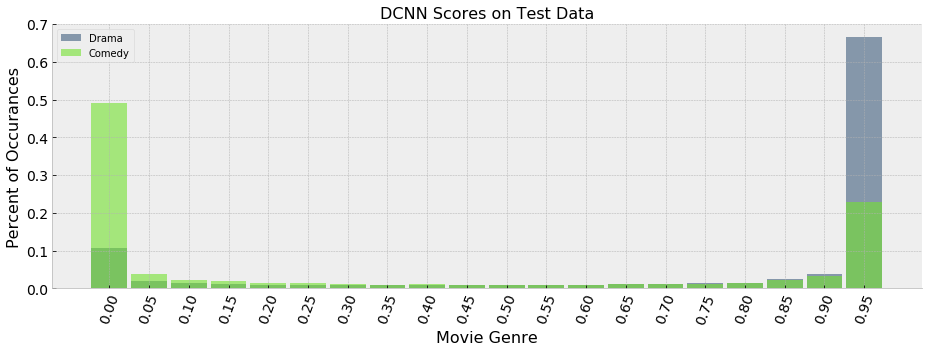

In [65]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("Movie Genre", fontsize=16)  
plt.ylabel("Percent of Occurances", fontsize=16)
plt.title('DCNN Scores on Test Data', fontsize=16)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in drama_probs], bins)
h_comedy, be = np.histogram([d[0] for d in comedy_probs], bins)
plt.bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend(['Drama', 'Comedy'])
plt.tight_layout()
plt.savefig('/Users/danfinkel/git_base/python/my_site/assets/images/histogram_drama_comedy_dcnn.png')

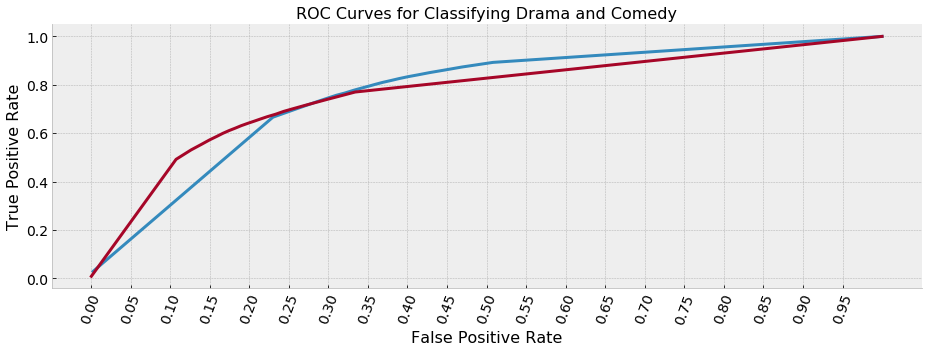

In [70]:
def roc_values(p1, p2):
    """
    compute true positive
    and false positive values
    relative to p1 and p2 vectors
    """
    tp = []
    fp = []
    for tt in np.arange(0, 1.05, 0.05):
        # tt is the threshold
        tp.append(1.0 * len([p for p in p1 if p[0] >= tt]) / len(p1))
        fp.append(1.0 * len([p for p in p2 if p[0] >= tt]) / len(p2))
        
    return tp, fp

drama_tp_dcnn, drama_fp_dcnn = roc_values(drama_probs, comedy_probs)
comedy_tp_dcnn, comedy_fp_dcnn = roc_values(1 - comedy_probs, 1 - drama_probs)

plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for Classifying Drama and Comedy', fontsize=16)

plt.plot(drama_fp_dcnn, drama_tp_dcnn, linewidth=3)
plt.plot(comedy_fp_dcnn, comedy_tp_dcnn, linewidth=3)
# plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
# plt.legend(['Drama', 'Comedy'])
plt.tight_layout()
plt.savefig('/Users/danfinkel/git_base/python/my_site/assets/images/roc_drama_comedy_dcnn.png')

### Log Regression Performance

In [12]:
X_ = df_test_drama['text'].values
lr_drama_scores = pipeline.predict_proba(X_)

X_ = df_test_not_drama['text'].values
lr_not_drama_scores = pipeline.predict_proba(X_)

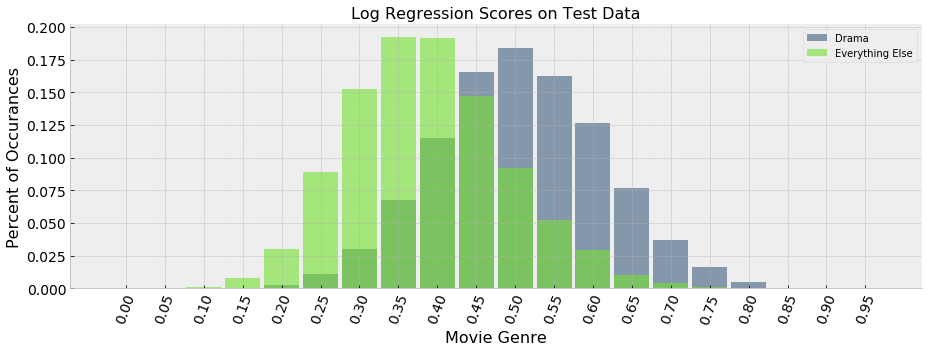

In [21]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("Movie Genre", fontsize=16)  
plt.ylabel("Percent of Occurances", fontsize=16)
plt.title('Log Regression Scores on Test Data', fontsize=16)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in lr_drama_scores], bins)
h_comedy, be = np.histogram([d[0] for d in lr_not_drama_scores], bins)
plt.bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend([GENRE, 'Everything Else'])
plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/histogram_drama_not_drama_lr.png')

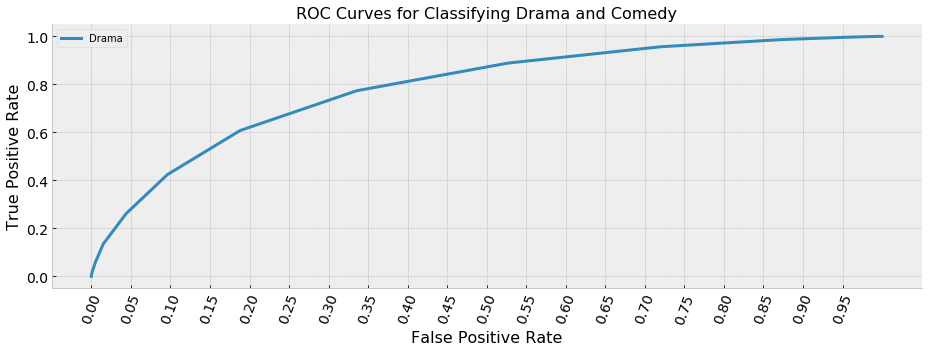

In [22]:
def roc_values(p1, p2):
    """
    compute true positive
    and false positive values
    relative to p1 and p2 vectors
    """
    tp = []
    fp = []
    for tt in np.arange(0, 1.05, 0.05):
        # tt is the threshold
        tp.append(1.0 * len([p for p in p1 if p[0] >= tt]) / len(p1))
        fp.append(1.0 * len([p for p in p2 if p[0] >= tt]) / len(p2))
        
    return tp, fp

drama_tp_lr, drama_fp_lr = roc_values(lr_drama_scores, lr_not_drama_scores)
comedy_tp_lr, comedy_fp_lr = roc_values(1 - lr_comedy_scores, 1 - lr_drama_scores)

plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for Classifying Drama and Comedy', fontsize=16)

plt.plot(drama_fp_lr, drama_tp_lr, linewidth=3)
# plt.plot(comedy_fp_lr, comedy_tp_lr, linewidth=3)
# plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend([GENRE])
plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/roc_drama_not_drama_lr.png')

## Classify All Genres

Build a bank of binary LR classifiers for each unique genre in the training set

In [26]:
df_neg = pd.read_csv('stanford_train_neg_genres.csv', encoding='utf-8')
df_pos = pd.read_csv('stanford_train_pos_genres.csv', encoding='utf-8')

df_train_all = pd.concat([df_neg, df_pos])
genres = df_train_all.columns[4:].values

In [ ]:
roc_data = []
for genre in genres:
    print 'Starting %s' % genre

    # Pull genre reviews for training
    df_train_genre = get_reviews("stanford_train",
                                 genre,
                                 "/Users/dfinkel/Downloads/aclImdb/train/",
                                 #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                1)
    df_train_genre['class'] = 0

    # Pull non-drama reviews
    df_train_not_genre = get_reviews("stanford_train",
                                     genre,
                                     "/Users/dfinkel/Downloads/aclImdb/train/",
                                  # "/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                    0)
    df_train_not_genre['class'] = 1

    # build training frame
    df_train = pd.concat([df_train_genre, df_train_not_genre])

    # shuffle rows
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    
    # drop duplicates
    df_train = df_train.drop_duplicates('text')

    X_ = df_train['text'].values
    Y_ = df_train['class'].values

    # Create classifier
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 3))),
        ('tf_idf', TfidfTransformer()),
        ('clf', LogisticRegression(C=0.39810717055349731, class_weight=None)),])
    
    # Train Classifier
    pipeline.fit(X_, Y_)
    
    # Pull genre reviews for testing
    df_test_genre = get_reviews("stanford_test",
                                 genre,
                                 "/Users/dfinkel/Downloads/aclImdb/test/",
                                 #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                1)

    # Pull non-drama reviews for testing
    df_test_not_genre = get_reviews("stanford_test",
                                     genre,
                                     "/Users/dfinkel/Downloads/aclImdb/test/",
                                  # "/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
                                    0)
    
    # Predict scores for in/out of genre predictions
    X_ = df_test_genre['text'].values
    lr_genre_scores = pipeline.predict_proba(X_)

    X_ = df_test_not_genre['text'].values
    lr_not_genre_scores = pipeline.predict_proba(X_)
    
    # Compute ROC values
    genre_tp_lr, genre_fp_lr = roc_values(lr_genre_scores, lr_not_genre_scores)
    
    roc_data.append([genre_tp_lr, genre_fp_lr])
    
    print 'Through %s' % genre

Starting Action
2569 1864 2569 1864
9902 10614 9902 10614
2827 1506 2827 1506
9632 10964 9632 10964
Through Action
Starting Adult
14 14 14 14
12457 12464 12457 12464
20 25 20 25
12439 12445 12439 12445
Through Adult
Starting Adventure
1504 1428 1504 1428
10967 11050 10967 11050
1658 1471 1658 1471
10801 10999 10801 10999
Through Adventure
Starting Animation
370 724 370 724
12101 11754 12101 11754
301 575 301 575
12158 11895 12158 11895
Through Animation
Starting Biography
323 686 323 686
12148 11792 12148 11792
359 632 359 632
12100 11838 12100 11838
Through Biography
Starting Comedy
3785 4335 3785 4335
8686 8143 8686 8143
3570 4256 3570 4256
8889 8214 8889 8214
Through Comedy
Starting Crime
1713 1996 1713 1996
10758 10482 10758 10482
1814 1832 1814 1832
10645 10638 10645 10638
Through Crime
Starting Documentary
274 539 274 539
12197 11939 12197 11939
242 512 242 512
12217 11958 12217 11958
Through Documentary
Starting Drama
5153 6589 5153 6589
7318 5889 7318 5889
